### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2021
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Introducción al Aprendizaje Automático

Integrantes: Carrion Nicolas, Delgado Gabriel

El objetivo de este práctico es probar distintos modelos de clasificación para evaluar la performance y la exactitud de predicción de cada modelo. 

* Utilizando el corpus normalizado en el práctico anterior, transformar el texto en vectores numéricos utilizando scikit-learn comparando los 3 modelos de vectorización. Explicar cada uno estos modelos.

* Clasificar los documentos por fuero. Trabajaremos con los siguientes modelos de clasificación de la librería scikit-learn: Logistic Regresion, Naive Bayes y SVM. En cada modelo probar distintos hiperparámetros, generar la Matriz de Confusión y la Curva ROC. Explicar los resultados obtenidos.

* Determinar y justificar cual es el modelo con mejor performance y predecir el fuero de un documento utilizando el mejor modelo.


Fecha de Entrega: 15 de agosto de 2021

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import itertools

In [2]:
def getListOfFiles(dirName, quantity=None):
    # create a list of file and sub directories 
    # names in the given directory
    files = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    if not quantity:
        for file in files:
            # Create full path
            fullPath = dirName + "\\" + file
            # If entry is a directory then get the list of files in this directory 
            if os.path.isdir(fullPath) and not quantity:
                allFiles = allFiles + getListOfFiles(fullPath)
            else:
                allFiles.append(fullPath)
    else:
        allFiles = allFiles + getListOfFiles(dirName)[:quantity]
    return allFiles

def create_corpus(file):
    corpus=[]
    f = open (file,'r', encoding="utf8")
    corpus=f.read()
    return corpus


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta correcta')
    plt.xlabel('Etiqueta predicha')
    

cant_letters=2
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b)
    return s
def limpieza_curacion(file):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens=tokenizer.tokenize(file)
    
    tokens_normalize = [normalize(word) for word in tokens]
    
    tokens_normalize=[token for token in tokens_normalize if len(token) > cant_letters]
    
    file_stopwords='stopwords.txt'
    f = open (file_stopwords,'r', encoding="utf-8")
    stopwords_list=f.read()
    #stopwords_list.replace('\n', ' ')
    stopwords_tokens=tokenizer.tokenize(stopwords_list)
    stopwords_tokens=stopwords.words('spanish')
    stopwords_tokens.extend(stopwords_tokens)
    words = [token for token in tokens_normalize if token not in stopwords_tokens]
    

    spanish_stemmer = SnowballStemmer('spanish')
    tokens_stemm=[spanish_stemmer.stem(word) for word in words]
    
    return tokens_stemm


def metrics_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    model_predict = model.predict(X_test)
    print('Metricas\n')
    print(classification_report(y_test, model_predict,zero_division=0))
    cm = confusion_matrix(y_test, model_predict, labels=['FAMILIA', 'LABORAL', 'MENORES', 'PENAL'])
    plot_confusion_matrix(cm, ['FAMILIA', 'LABORAL', 'MENORES', 'PENAL'])
    print("Accuracy:", round(accuracy_score(y_test, model_predict), 2))
    print("Precision:", round(precision_score(y_test, model_predict, average='macro'),2))
    print("Recall:", round(recall_score(y_test, model_predict, average='macro'),2))
    print("F1 score:", round(f1_score(y_test, model_predict, average='macro'),2))
    
def hyper(model, X_train, X_test, y_train, y_test):
    if model == 'LR':
        param_grid = {'penalty': ['l1', 'l2', 'none'],
                      'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
                      'C': [0.01, 0.1, 1, 10],
                      'max_iter': [5,25,50],
                      'class_weight': [None, 'balanced']}
        model1 = LogisticRegression()
    elif model == 'NB':
        param_grid = {'alpha': np.random.uniform(0,5,100),
                     'fit_prior': [True, False]}
        model1 = MultinomialNB()
    elif model == 'SVM':
        param_grid = {'kernel': ['linear','poly','rbf'],
                      'gamma': ['scale', 'auto'],
                      'C' : [0.1, 1, 10],
                      'degree': [1,5,10],
                      'decision_function_shape': ['ovo', 'ovr']}
        model1 = SVC()
    else:
        return print('Modelo no valido')

    gsCV = GridSearchCV(model1, param_grid = param_grid, cv = 5, scoring = 'f1_macro').fit(X_train, y_train)
    
    print('Mejores hiperparametros: ', gsCV.best_estimator_)
    
    metrics_models(gsCV, X_train, X_test, y_train, y_test)
    
    return gsCV


def prediccion(model, vectorizer_transform, files):
    data_predict= pd.DataFrame(files, columns=['file'])
    data_predict['fuero']= data_predict['file'].apply(lambda x: x.split('\\')[-2])
    data_predict['texto']= data_predict['file'].apply(lambda x: create_corpus(x))
    data_predict['texto']= data_predict['texto'].apply(lambda x: ' '.join(limpieza_curacion(x)))
    X_predict,Y_predict=transform.transform(data_predict['texto']), data_predict['fuero']
    predict = model.predict(X_predict)
    print(classification_report(Y_predict, predict,zero_division=0))
    cm = confusion_matrix(Y_predict, predict, labels=['FAMILIA', 'LABORAL', 'MENORES', 'PENAL'])
    plot_confusion_matrix(cm, ['FAMILIA', 'LABORAL', 'MENORES', 'PENAL'])
    print("Las prediccion sobre los documentos fueron: ",predict)
    print("Los valores reales sobre los documentos es: ", Y_predict.tolist())

Se crea y normaliza el Corpus.


Ademas se crea un dataframa donde se divide el corpus por fuero para una mayor facilidad en el manejo de los algoritmos de clasificacion que se van a usar en esta entrega

In [3]:
fueros=['FAMILIA', 'LABORAL', 'MENORES', 'PENAL']
root=os.getcwd()
dirname=f'{root}\\Documentos'
files=getListOfFiles(dirname)

Separamos 4 documentos (podrian ser mas) del conjunto que se va a utilizar para entrenar y validar, con el fin de hacer una ultima prueba sobre el mejor modelo y ver de forma 100% real como clasifica, ya que estos archivos no fueron vistos nunca por el modelo. 

In [4]:
files_for_final_testing= 4
test_files=random.sample(files, files_for_final_testing)
for file in test_files:
    files.remove(file)

In [6]:
data= pd.DataFrame(files, columns=['file'])
data['fuero']= data['file'].apply(lambda x: x.split('\\')[-2])
data['texto']= data['file'].apply(lambda x: create_corpus(x))
data['texto']= data['texto'].apply(lambda x: ' '.join(limpieza_curacion(x)))
data['fuero'].value_counts()

FAMILIA    123
PENAL       51
LABORAL     37
MENORES     28
Name: fuero, dtype: int64

In [7]:
data.head()

,file,fuero,texto
0,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,FAMILIA,aut 122 547 552 cordob veinticuatr septiembr d...
1,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,FAMILIA,aut cordob nuev febrer dos mil diecioch vist e...
2,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,FAMILIA,dat caus sed ciud cordob dependent cam famili ...
3,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,FAMILIA,cam famili nominacion cordob resolucion aut 10...
4,C:\Users\Usuario\Mentoria_Busqueda_y_Recomenda...,FAMILIA,aut 164 fech 2016 cordob quinc noviembr dos mi...


No podemos trabajar directamente con texto cuando usamos algoritmos de aprendizaje automático. En su lugar, necesitamos convertir el texto a números.

Para esto vamos a usar 3 modelos de vectoriacion 

<ul>
    <li> CountVectorizer </li>
    <li> TfidfVectorizer </li>
    <li> HashingVectorizer </li>
</ul>







***CountVectorizer***


Count Vectorizer convierte una colección de documentos de texto en una matriz de recuentos de tokens Esta implementación produce una representación escasa de los recuentos usando scipy.sparse.csr_matrix.

Si no proporciona un diccionario a-priori y no utiliza un analizador que haga algún tipo de selección de características, entonces el número de características será igual al tamaño de vocabulario encontrado al analizar los datos, es decir no hay palabras repetidas.

Como argumento se puede pasar una lista de stopwords a tener en cuenta, nosotros no lo utilizamos por que ya eliminamos los stopwords previamente

In [8]:
vectorizer = CountVectorizer()
vector_fit = vectorizer.fit_transform(data['texto'])
print(vector_fit.shape)
print(vector_fit.toarray())
#print(vectorizer.vocabulary_) #Para ver todas las palabras y sus frecuencias, esta comentado para no dejar improlija la notebook

(239, 13896)
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


***TfidfVectorizer***

En un corpus de texto extenso, algunas palabras estarán muy presentes (por ejemplo, "el", "a", "la"), por lo que contienen muy poca información significativa sobre el contenido real del documento. Si tuviéramos que alimentar los datos de recuento directo directamente a un clasificador, esos términos muy frecuentes ensombrecerían las frecuencias de términos más raros pero más interesantes.

Para volver a ponderar las características de conteo en valores de punto flotante adecuados para su uso por un clasificador, es muy común usar la transformación tf-idf.

Tf significa término-frecuencia mientras que tf-idf significa término-frecuencia multiplicado por la frecuencia inversa del documento. Este es un esquema de ponderación de términos comunes en la recuperación de información, que también ha encontrado un buen uso en la clasificación de documentos.

El objetivo de utilizar tf-idf en lugar de las frecuencias brutas de ocurrencia de un token en un documento dado es reducir el impacto de los tokens que ocurren con mucha frecuencia en un corpus dado y que, por lo tanto, son empíricamente menos informativos que las características que ocurren en un determinado corpus. pequeña fracción del corpus de formación.

In [9]:
transformer = TfidfVectorizer()
tfidf = transformer.fit_transform(data['texto'])
print(tfidf.shape)
print(tfidf.toarray())

(239, 13896)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00908031 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


***HashingVectorizer***

Convierte una colección de documentos de texto en una matriz scipy.sparse que contiene recuentos de ocurrencia de tokens (o información de ocurrencia binaria), posiblemente normalizada como frecuencias de tokens si norm = 'l1' o proyectada en la esfera de la unidad euclidiana si norm = 'l2'.

Esta implementación de vectorizador de texto usa el truco de hash para encontrar el nombre de la cadena del token para presentar el mapeo de índice entero.

Lo bueno es que ocupa poco espacio en memoria.

In [10]:
hv = HashingVectorizer()
hv.transform(data["texto"])

<239x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 195838 stored elements in Compressed Sparse Row format>

_Para los puntos siguientes utilizaremos TfidfVectorizer por que creemos que es mejor que Count Vectorizer porque no solo se centra en la frecuencia de las palabras presentes en el corpus, sino que también proporciona la importancia de las palabras y en nuestro caso puede ser un diferencial grande._

### Clasificar los documentos por fuero

_Una vez elegido nuestro modelo de vectorizacion, procedemos a dividir nuestro dataset en un conjunto de entrenamiento (70%) y en un conjunto de test (30%) sobre la que evaluaremos nuestro modelo entrenado.
Se pueden elegir diferentes proporciones de separacion del conjunto de train y test. En un comienzo utilizamos (80/20), pero como vimos que los modelos aprendian muy bien, preferimos dejar mas ejemplos de test como una medida de prevencion al overfitting._

Usaramos 3 modelo de clasificacion

<ul>
    <li> Logistic Regresion (LogisticRegression) </li>
    <li> Naive Bayes (MultinomialNB) </li>
    <li> SVM (SVC) </li>
</ul>

Ademas para medir el rendimientos de nuestros modelos usaremos las siguientes metricas.

+ Matriz de confusión: La matriz compara los valores reales con los predichos por el modelo de aprendizaje. Esto nos ayuda a ver que tan bien está funcionando nuestro modelo.
Los elementos diagonales representan el número de puntos para los cuales la etiqueta predicha es igual a la etiqueta verdadera, mientras que cualquier cosa fuera de la diagonal fue mal etiquetada por el clasificador. Por lo tanto, cuanto más altos sean los valores diagonales de la matriz de confusión, mejor, indicando muchas predicciones correctas.

+ Accuracy: Mide la frecuencia con la que el clasificador hace la predicción correcta. Es la relación entre el número de predicciones correctas y el número total de predicciones.
La desventaja de usar esta métrica es que no funciona bien cuando las clases están desbalanceadas.

+ Precision: Esta métrica representa el número de verdaderos positivos que son realmente positivos en comparación con el número total de valores positivos predichos.

+ Recall: La métrica de recall muestra la cantidad de verdaderos positivos que el modelo ha clasificado en función del número total de valores positivos.

+ F1: Esta métrica es la combinación de las métricas de precision y recall y sirve de compromiso entre ellas. La mejor puntuación F1 es igual a 1 y la peor a 0.

Para problemas con clases desbalanceadas es mucho mejor usar precision, recall y F1

In [11]:
vectorizer = TfidfVectorizer()
transform = vectorizer.fit(data['texto'])
X,Y=transform.transform(data['texto']), data['fuero']
X_train, X_test, y_train, y_test=train_test_split(X,Y, test_size=0.3, random_state=42)

***Logistic Regresion (LogisticRegression)***

La regresión logística es un método estadístico que trata de modelar la probabilidad de una variable cualitativa binaria (dos posibles valores) en función de una o más variables independientes. 
La principal aplicación de la regresión logística es la creación de modelos de clasificación binaria.

Regresión logística multinomial es una extensión de la regresión logística que agrega soporte nativo para problemas de clasificación de clases múltiples.

- **Regresión logística binomial:** Regresión logística estándar que predice una probabilidad binomial (es decir, para dos clases) para cada ejemplo de entrada.
- **Regresión logística multinomial:** Versión modificada de la regresión logística que predice una probabilidad multinomial (es decir, más de dos clases) para cada ejemplo de entrada.

En nuestro caso, utilizaremos la Regresion logistica multinomial

Metricas

              precision    recall  f1-score   support

     FAMILIA       0.95      1.00      0.97        36
     LABORAL       1.00      1.00      1.00        11
     MENORES       1.00      0.78      0.88         9
       PENAL       1.00      1.00      1.00        16

    accuracy                           0.97        72
   macro avg       0.99      0.94      0.96        72
weighted avg       0.97      0.97      0.97        72

Accuracy: 0.97
Precision: 0.99
Recall: 0.94
F1 score: 0.96


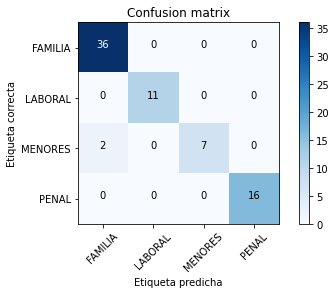

In [12]:
metrics_models(LogisticRegression(), X_train, X_test, y_train, y_test)

_Modelamos utilizando Regression logistica con los parametros por defecto y pudimos observar que los resultados observados para cada clase en el classification report fueron muy buenos, el modelo obtuvo excelentes metricas evaluandolas en el conjunto de test. 
En la matriz de confusion podemos observar que unicamente hay un error en 2 documentos ne los cuales se predicen como menores, y en realidad pertenecen a familia._

**Importante**: Cabe aclarar que tanto en este modelo como en los siguientes, no se pudo cumplir con el punto de la Curva ROC debido a que para clasificacion multiclase no se suele utilizar y no hay muchas librerias que funcionen con ese objetivo. Encontramos una (https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html) y tratamos de seguir con la documentacion sugerida, pero los resultados que observamos no tenian sentido, asi que decidimos dejar este punto sin responder.

***Naive Bayes (MultinomialNB)***

Naive Bayes Classifier es un algoritmo de aprendizaje automático supervisado basado en el teorema de Bayes. Es un algoritmo simple pero muy poderoso que funciona bien con grandes
conjuntos de datos y matrices dispersas, como datos de texto preprocesados que crean miles de vectores dependiendo de la cantidad de palabras en un diccionario. Funciona muy bien con proyectos
de datos de texto como el análisis de datos de opinión, funciona bien con proyectos de categorización de documentos y también es excelente para predecir datos categóricos en proyectos como la
clasificación de correo no deseado.

En nuestro caso usaremos MultinomialBN, que es adecuado para la clasificación con características discretas (por ejemplo, recuento de palabras para la clasificación de texto).

Metricas

              precision    recall  f1-score   support

     FAMILIA       0.53      1.00      0.69        36
     LABORAL       0.00      0.00      0.00        11
     MENORES       0.00      0.00      0.00         9
       PENAL       1.00      0.25      0.40        16

    accuracy                           0.56        72
   macro avg       0.38      0.31      0.27        72
weighted avg       0.49      0.56      0.44        72

Accuracy: 0.56
Precision: 0.38
Recall: 0.31
F1 score: 0.27


C:\Users\Usuario\Anaconda3\envs\mentoria_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


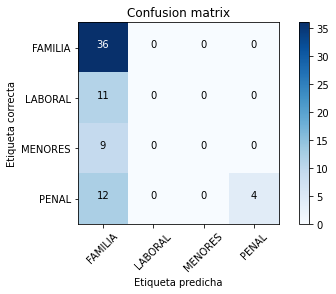

In [13]:
metrics_models(MultinomialNB(), X_train, X_test, y_train, y_test)

_AL entrenar el modelo con NaiveBayes Multinomial con los parametros por defecto, se puede observar que el modelo predice casi todo el conjunto de datos como Familia, eso podria darse por el desbalance en la cantidad de documentos de esa clase. Mas adelante veremos como mejora el modelo utilizando la optimizacion de hiperparametros_

***SVM (SVC)***

Support Vector Machines (SVM) es un algoritmo de clasificación y regresión. 
Aunque inicialmente se desarrolló como un método de clasificación binaria, su aplicación se ha extendido a problemas de clasificación múltiple y regresión. SVMs ha resultado ser uno de los 
mejores clasificadores para un amplio abanico de situaciones, por lo que se considera uno de los referentes dentro del ámbito de aprendizaje estadístico y machine learning.

Metricas

              precision    recall  f1-score   support

     FAMILIA       0.95      1.00      0.97        36
     LABORAL       1.00      1.00      1.00        11
     MENORES       1.00      0.78      0.88         9
       PENAL       1.00      1.00      1.00        16

    accuracy                           0.97        72
   macro avg       0.99      0.94      0.96        72
weighted avg       0.97      0.97      0.97        72

Accuracy: 0.97
Precision: 0.99
Recall: 0.94
F1 score: 0.96


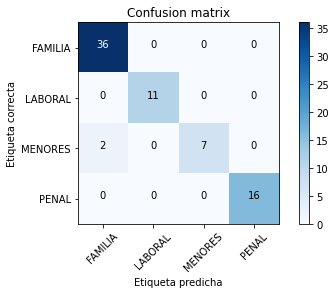

In [14]:
metrics_models(SVC(), X_train, X_test, y_train, y_test)

_El modelo de SVM con los parametros por defecto performo muy bien y nos dio metricas mas que aceptables_

_Como primera conclusion al ejecutar los modelos con los parametros por defecto pudimos observar que tanto SVM y Regresion Logistica tuvieron resultados mas que aceptables, brindando metricas practicamente identicas. Por otro lado el modelo de Naive Bayes, nos dio malos resultados, por lo cual, deberia ser el modelo mas optimizable en los puntos siguiente_

***Optimizacion de hiperparametros con GridSearch***

Para la optimizacion de hiperparametros con GridSearch utilizamos como metrica de scoring el F1, debido a que cuando las clases estan desbalanceadas, no se recomienda como buena practica utilizar el accuracy

***Regresion Logistica***

- penalty: Se utiliza para especificar la norma utilizada en la penalización. (Link con data interesante sobre los penalties l1 y l2 https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)
- C: Inversa de la fuerza de regularización; debe ser un flotador positivo. Al igual que en las máquinas de vectores de soporte, los valores más pequeños especifican una regularización más fuerte.
- mac_iter: Número máximo de iteraciones que se toman para que los solucionadores converjan.
- class_weight: Pesos asociados a clases en el formulario . Si no se da, se supone que todas las clases tienen un peso uno. El modo "balanceado" utiliza los valores de y para ajustar automáticamente los pesos de forma inversamente proporcional a las frecuencias de clase en los datos de entrada como .n_samples / (n_classes * np.bincount(y))
- solver: Algoritmo a utilizar en el problema de optimización.Para conjuntos de datos pequeños, 'liblinear' es una buena opción, mientras que 'sag' y 'saga' son más rápidos para los grandes.Para problemas multiclase, solo 'newton-cg', 'sag', 'saga' y 'lbfgs' manejan la pérdida multinomial; 'liblinear' se limita a esquemas uno versus resto.

C:\Users\Usuario\Anaconda3\envs\mentoria_env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Usuario\Anaconda3\envs\mentoria_env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Usuario\Anaconda3\envs\mentoria_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Usuario\Anaconda3\envs\mentoria_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

Mejores hiperparametros:  LogisticRegression(C=0.01, max_iter=25, penalty='none', solver='sag')


C:\Users\Usuario\Anaconda3\envs\mentoria_env\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Usuario\Anaconda3\envs\mentoria_env\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Usuario\Anaconda3\envs\mentoria_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Usuario\Anaconda3\envs\mentoria_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this tra

Metricas

              precision    recall  f1-score   support

     FAMILIA       0.97      1.00      0.99        36
     LABORAL       1.00      1.00      1.00        11
     MENORES       1.00      0.89      0.94         9
       PENAL       1.00      1.00      1.00        16

    accuracy                           0.99        72
   macro avg       0.99      0.97      0.98        72
weighted avg       0.99      0.99      0.99        72

Accuracy: 0.99
Precision: 0.99
Recall: 0.97
F1 score: 0.98


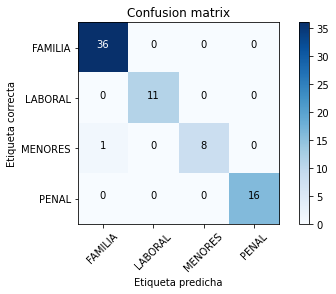

In [15]:
best_LR = hyper('LR', X_train, X_test, y_train, y_test)

In [16]:
print('Mejores hiperparametros: ', best_LR.best_estimator_)

Mejores hiperparametros:  LogisticRegression(C=0.01, max_iter=25, penalty='none', solver='sag')


Metricas

              precision    recall  f1-score   support

     FAMILIA       0.95      1.00      0.97        36
     LABORAL       1.00      1.00      1.00        11
     MENORES       1.00      0.78      0.88         9
       PENAL       1.00      1.00      1.00        16

    accuracy                           0.97        72
   macro avg       0.99      0.94      0.96        72
weighted avg       0.97      0.97      0.97        72

Accuracy: 0.97
Precision: 0.99
Recall: 0.94
F1 score: 0.96


C:\Users\Usuario\Anaconda3\envs\mentoria_env\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Usuario\Anaconda3\envs\mentoria_env\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


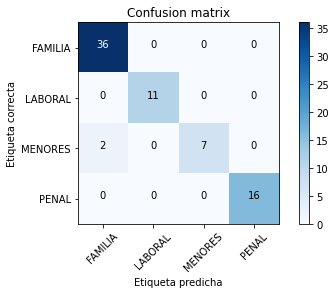

In [17]:
metrics_models(LogisticRegression(C=0.01, max_iter=5, penalty='none', solver='saga'), X_train, X_test, y_train, y_test)

En la notebook saltan diferentes alertas y excepciones de combinacion de hiperparametros que no son compatibles entre si.

_En cuanto a los resultados, la optimizacion de hiperparametros mejoro las metricas del modelo y predice perfecto al conjunto de test, de acuerdo a lo que podemos ver en los resultados. Hay que analizar si esto es por overfittin o no. Por lo cual al final de la notebook probaremos predecir con los documentos que estaban fuera de la muestra. Con respecto a los hiperparametros nos parecio curioso que el metodo de regularizacion con el que mejor performo (penalty) es None, recordando que la regularizacion en alguna medida ayuda a evitar el overfitting)_

***Naive Bayes***

Para Naive Bayes optimizaremos los siguientes hiperparametros:
- alpha: Parámetro de suavizado aditivo (Laplace / Lidstone)    
- fit_prior: Es aprender las probabilidades previas de la clase o no. Si es falso, se usará un uniforme previo.

Mejores hiperparametros:  MultinomialNB(alpha=0.06674750733755674, fit_prior=False)
Metricas

              precision    recall  f1-score   support

     FAMILIA       0.88      1.00      0.94        36
     LABORAL       1.00      1.00      1.00        11
     MENORES       1.00      0.44      0.62         9
       PENAL       1.00      1.00      1.00        16

    accuracy                           0.93        72
   macro avg       0.97      0.86      0.89        72
weighted avg       0.94      0.93      0.92        72

Accuracy: 0.93
Precision: 0.97
Recall: 0.86
F1 score: 0.89


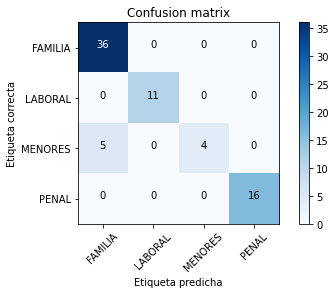

In [18]:
best_NB = hyper('NB', X_train, X_test, y_train, y_test)

_En el caso de Naive Bayer optimizado podemos ver que paso de predecir muy mal con los parametros por defecto a predecir perfecto. Tambien cabe aclarar que los 2 hiperparametros que optimizamos varian bastante con el valor por defecto, el alpha por defecto es de 1 y en el mejor modelo es de 0.03 y en el caso del fit_prior que por defecto es verdadero, aca se considero que es mas optimo que sea falso_

***SVM***

Para este modelo probamos optimizar los siguientes hiperparametros:
- kernel:Especifica el tipo de kernel que se utilizará en el algoritmo. (https://www.geeksforgeeks.org/major-kernel-functions-in-support-vector-machine-svm/ para mas info)
- gamma: Coeficiente de kernel para 'rbf', 'poli' y 'sigmoide'.
- C :Parámetro de regularización. La fuerza de la regularización es inversamente proporcional a C. Debe ser estrictamente positiva. La penalización es una penalización de 12 al cuadrado.
- degree:Grado de la función del núcleo polinomial ('poli'). Ignorado por todos los demás núcleos.
- decision_function_shape: Ya sea para devolver una función de decisión one-vs-rest ('ovr') de shape (n_samples, n_classes) como todos los demás clasificadores, o la función de decisión original one-vs-one ('ovo') de libsvm que tiene shape

Mejores hiperparametros:  SVC(C=10, decision_function_shape='ovo', degree=1, kernel='linear')
Metricas

              precision    recall  f1-score   support

     FAMILIA       0.95      1.00      0.97        36
     LABORAL       1.00      1.00      1.00        11
     MENORES       1.00      0.78      0.88         9
       PENAL       1.00      1.00      1.00        16

    accuracy                           0.97        72
   macro avg       0.99      0.94      0.96        72
weighted avg       0.97      0.97      0.97        72

Accuracy: 0.97
Precision: 0.99
Recall: 0.94
F1 score: 0.96


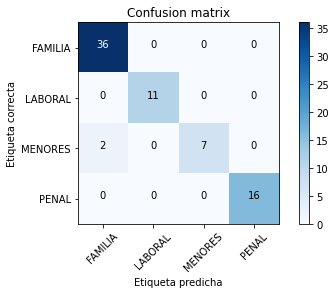

In [19]:
best_SVM = hyper('SVM', X_train, X_test, y_train, y_test)

_Vemos que en el caso de SVM mejora infimamente las metricas del modelo que obteniamos con los hiperparametros por defecto, a pesar de modificarse bastante los valores de estos hiperparametros_

***Evaluacion con datos fuera de la muestra***

Ahora vamos a evaluar el rendimiento de los mejores modelos, en nuestro caso Regresion Logistica y Naive Bayes opmitizados, para corroborar si efectivamente aprendieron bien.

In [20]:
test_files

['C:\\Users\\Usuario\\Mentoria_Busqueda_y_Recomendacion_Textos_Legales\\Documentos\\PENAL\\040-Velazquez, Alexis Fabio.pdf.txt',
 'C:\\Users\\Usuario\\Mentoria_Busqueda_y_Recomendacion_Textos_Legales\\Documentos\\MENORES\\8°-2013-S., C.B. - Control de legalidad.doc.txt',
 'C:\\Users\\Usuario\\Mentoria_Busqueda_y_Recomendacion_Textos_Legales\\Documentos\\PENAL\\056-Bustos, César Gabriel (Nantt, Lucila) Inconstitucionalidad.pdf.txt',
 'C:\\Users\\Usuario\\Mentoria_Busqueda_y_Recomendacion_Textos_Legales\\Documentos\\FAMILIA\\P., A.M. c  P.-CARTA PODER SIN CERTIFICAR FIRMA-.doc.txt']

              precision    recall  f1-score   support

     FAMILIA       1.00      1.00      1.00         1
     MENORES       1.00      1.00      1.00         1
       PENAL       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Las prediccion sobre los documentos fueron:  ['PENAL' 'MENORES' 'PENAL' 'FAMILIA']
Los valores reales sobre los documentos es:  ['PENAL', 'MENORES', 'PENAL', 'FAMILIA']


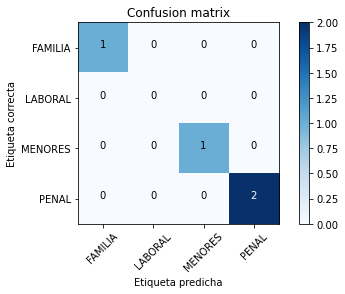

In [21]:
prediccion(best_NB, transform, test_files)


Vemos que con Naive Bayes se predicen bien los modelos, lo cual nos acerca un poco mas a la hipotesis de que el modelo realmente aprendio bien y no hizo overfitting 

              precision    recall  f1-score   support

     FAMILIA       1.00      1.00      1.00         1
     MENORES       1.00      1.00      1.00         1
       PENAL       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Las prediccion sobre los documentos fueron:  ['PENAL' 'MENORES' 'PENAL' 'FAMILIA']
Los valores reales sobre los documentos es:  ['PENAL', 'MENORES', 'PENAL', 'FAMILIA']


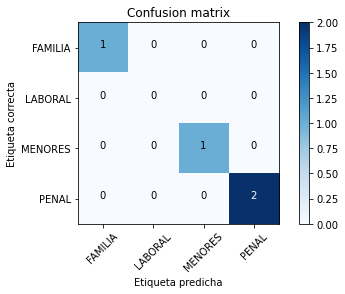

In [22]:
prediccion(best_LR, transform, test_files)

Con Regression Logistica tambien obtuvimos un buen resultado

***Conclusiones***



Si bien a lo largo de la notebook fuimos describiendo toda las conclusiones que fuimos sacando, podemos hacer un resumen de lo siguiente:
- Probamos utilizar los 3 metodos de vectorizacion que nos brindaba sklearn y nos terminamos quedando con TfidfVectorizer por que ademas de tener en cuenta el recuento de palabras, les proporciona importancia
- Separamos algunos documentos fuera de la muestra para hacer una evaluacion final de los mejores modelos y con al resto de los documentos los volvido a dividir en (70/30) para formar el conjunto de entrenamiento y test respectivamente
- Probamos entrenar los 3 modelos solicitados (Regresion logistica, Naive Bayes y SVM) con los parametros por defecto y pudimos observar que tanto LR como SVM performaron ambos muy bien, en tanto que Naive Bayes perfomo mal.
- Posteriormente optmizamos los modelos con diferentes hiperparametros correspondientes a cada uno, lo cual nos llevo a aprender para que sirven y que ajusten implican cada uno. Con esta optimizacion, pudimos ver que LR y NB performaron perfecto evaluando el conjunto de test, lo cual nos llevo a pensar que podria haber overfitting. SVM tambien mejoro ligeramente con respecto a los valores por defecto.
- Por ultimo, evaluamos los archivos que habiamos separado en el punto 2 y tratamos de predecirlos con los mejores modelos y fueron predichos de forma correcta, lo cual nos deja a entender que los modelos efectivamente aprendieron bien 